In [1]:
import argparse
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch.nn.utils.spectral_norm as spectralnorm
import torchvision
import matplotlib.pyplot as plt

from models import *
from utils import *
from helper import *

In [2]:
!nvidia-smi

Fri Feb 23 11:08:49 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:06:00.0 Off |                    0 |
| N/A   37C    P8    15W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available else cpu)

In [5]:
def set_models_state(list_models, state):
    if state =='train':
        for model in list_models:
            model.train()
    else:
        for model in list_models:
            model.eval()

def set_opt_zero(opts):
    for opt in opts:
        opt.zero_grad()
        
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0),  1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake[:,0],
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def cal_W1(ssf, encoder, decoder, decoder_hat, discriminator, discriminator_M, test_loader, list_models):
    mse_loss = nn.MSELoss(reduction='sum')
    mse_avg = nn.MSELoss()
    set_models_state(list_models, 'eval')

    W1_distance = []
    W1M_distance = []
    MSE = []

    num_x = 0
    for i, x in enumerate(iter(test_loader)):
        with torch.no_grad():
            #Get the data
            x = x.permute(0, 4, 1, 2, 3)
            x = x.cuda().float()
            x_cur = x[:,:,1,...]
            with torch.no_grad():
                hx = encoder(x[:,:,0,...])[0]
                x_ref = decoder(hx).detach()
                x_1_hat = decoder_hat(hx).detach()
            #x_ref[x_ref < 0.1] = 0.0
            x_hat = ssf(x_cur, x_ref, x_1_hat)


            fake_vid = torch.cat((x_1_hat, x_hat), dim = 1).detach()
            real_vid = x[:,0,:2,...].detach() #this looks good!

            fake_validity = discriminator(fake_vid)
            real_validity = discriminator(real_vid)

            fake_img = x_hat.detach()
            real_img = x[:,0,6:7,...].detach()
            fake_valid_m = discriminator_M(fake_img)
            real_valid_m = discriminator_M(real_img)

            W1_distance.append(torch.sum(real_validity) - torch.sum(fake_validity))
            W1M_distance.append(torch.sum(real_valid_m) - torch.sum(fake_valid_m))
            #print (F.mse_loss(x[:,:,1,:,:], x_hat)* x.size()[0])
            MSE.append(mse_loss(x[:,:,1,:,:], x_hat))
            num_x += len(x)

    W1_distance = torch.Tensor(W1_distance)
    W1M_distance = torch.Tensor(W1M_distance)
    MSE = torch.Tensor(MSE)

    return W1M_distance.sum()/num_x, W1_distance.sum()/num_x, MSE.sum()/(64*64*num_x)


In [13]:
#modified test function for new metric
def cal_W1_new(ssf, encoder, decoder, decoder_hat, discriminator, discriminator_N, test_loader, list_models):
    mse_loss = nn.MSELoss(reduction='sum')
    mse_avg = nn.MSELoss()
    set_models_state(list_models, 'eval')

    W1_distance = []
    W1N_distance = []#N stands for 'New'
    MSE = []

    num_x = 0
    for i, x in enumerate(iter(test_loader)):
        with torch.no_grad():
            #Get the data
            x = x.permute(0, 4, 1, 2, 3)
            x = x.cuda().float()
            x_cur = x[:,:,1,...] # x_2
            with torch.no_grad():
                hx = encoder(x[:,:,0,...])[0]
                x_ref = decoder(hx).detach()
                x_1_hat = decoder_hat(hx).detach()
            x_2_hat = ssf(x_cur, x_ref, x_1_hat) # x_hat is x2_hat

            fake_vid = torch.cat((x_1_hat, x_2_hat), dim = 1).detach()
            real_vid = x[:,0,:2,...].detach()
            fake_validity = discriminator(fake_vid)
            real_validity = discriminator(real_vid)
            
            new_metric_real_vid = torch.cat((x_1_hat, x_cur), dim = 1).detach()
            new_metric_real_validity = discriminator_N(new_metric_real_vid) # # substitute real video by new_metric_vid
            new_metric_fake_validity = discriminator_N(fake_vid) # substitute new_metric_vid by fake_vid

            W1N_distance.append(torch.sum(new_metric_real_validity) - torch.sum(new_metric_fake_validity))
            W1_distance.append(torch.sum(real_validity) - torch.sum(fake_validity))
            MSE.append(mse_loss(x[:,:,1,:,:], x_2_hat))
            num_x += len(x)
            #break

    W1_distance = torch.Tensor(W1_distance)
    MSE = torch.Tensor(MSE)
    W1N_distance = torch.Tensor(W1N_distance)

    return (W1_distance.sum()/num_x).item(), (MSE.sum()/(64*64*num_x)).item(), (W1N_distance.sum()/num_x).item()

In [14]:
#code to test call_W1_new()

discriminator = Discriminator_v3(out_ch=2).to(device) #Generator Side
discriminator_N = Discriminator_v3(out_ch=2).to(device) #Generator Side
ssf = ScaleSpaceFlow_R1eps(num_levels=1, dim=8, stochastic=True, quantize_latents=True, L=2).to(device)

list_models = [discriminator, discriminator_N, ssf]

encoder = Encoder(dim=12, nc=1, stochastic=True, quantize_latents=True, L=2).to(device) #Generator Side
decoder = Decoder_Iframe(dim=12).to(device) #Generator Side
decoder_hat = Decoder_Iframe(dim=12).to(device)

train_loader, test_loader = get_dataloader(data_root='./data/', seq_len=8, batch_size=64, num_digits=1)

cal_W1_new(ssf, encoder, decoder, decoder_hat, discriminator, discriminator_N, test_loader, list_models)

[-1.0, 1.0]
[-1.0, 1.0]
Finished Loading MNIST!


(-90644.8828125, 0.2323826551437378, -82575.921875)

In [48]:
def main_new(dim = 128,
        z_dim = 12,
        lambda_gp = 10,
        bs = 64,
        d_penalty = 0,
        skip_fq = 1,
        total_epochs = 3,
        lambda_P = 0,
        lambda_PN = 0,
        lambda_MSE = 1,
        L = 2,
        path = './data/',
        pre_path = 'None'):
        
    #No quantization:
    stochastic = True
    quantize_latents = True
    if L == -1:
        stochastic = False
        quantize_latents = False
    #Create folder:
    folder_name='R1-eps|dim_'+str(dim)+'|z_dim_'+str(z_dim)+'|L_'+str(L)+'|lambda_gp_'+str(lambda_gp) \
        +'|bs_'+str(bs)+'|dpenalty_'+str(d_penalty)+'|lambdaP_'+str(lambda_P)+'|lambdaPM_'+str(lambda_PN)+'|lambdaMSE_' + str(lambda_MSE)
    print ("Settings: ", folder_name)

    os.makedirs('./saved_models/'+ folder_name, exist_ok=True)
    f = open('./saved_models/'+ folder_name + "/performance.txt", "a")

    #Define Models
    discriminator = Discriminator_v3(out_ch=2).to(device) #Generator Side
    discriminator_N = Discriminator_v3(out_ch=2).to(device) #Marginal Discriminator
    ssf = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=stochastic, quantize_latents=quantize_latents, L=L).to(device)
    list_models = [discriminator, discriminator_N, ssf]

    #Load models:
    if pre_path != 'None':
        ssf.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
        ssf.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
        ssf.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
        ssf.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
        ssf.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
        discriminator.load_state_dict(torch.load(pre_path+'/discriminator.pth'))
        discriminator_M.load_state_dict(torch.load(pre_path+'/discriminator_N.pth'))
    
    #Define fixed models
    I_dim = 12 
    I_L = 2
    encoder = Encoder(dim=I_dim, nc=1, stochastic=True, quantize_latents=True, L=I_L).to(device).eval() #Generator Side
    decoder = Decoder_Iframe(dim=I_dim).to(device).eval()
    decoder_hat = Decoder_Iframe(dim=I_dim).to(device).eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #Define Data Loader
    train_loader, test_loader = get_dataloader(data_root=path, seq_len=8, batch_size=bs, num_digits=1)
    loader_l = len(train_loader)
    mse = torch.nn.MSELoss()

    #Define optimizers
    opt_ssf= torch.optim.RMSprop(ssf.parameters(), lr=1e-5)
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=5e-5)
    opt_dn = torch.optim.RMSprop(discriminator_N.parameters(), lr=5e-5)
    list_opt = [opt_ssf, opt_d, opt_dn]

    
    for epoch in range(total_epochs):
        set_models_state(list_models, 'train')
        a1 = time.time()
        for i,x in enumerate(train_loader):
            if i%100 ==0:
                print(f'{i}/{loader_l}')
            set_opt_zero(list_opt)
            
            #Get the data
            x = x.permute(0, 4, 1, 2, 3)
            x = x.cuda().float()
            x_cur = x[:,:,1,...]
            with torch.no_grad():
                hx = encoder(x[:,:,0,...])[0]
                x_ref = decoder(hx).detach()
                x_1_hat = decoder_hat(hx).detach()
                x_hat = ssf(x_cur, x_ref, x_1_hat)


            
            #Optimize discriminator
            fake_vid = torch.cat((x_1_hat, x_hat), dim = 1)
            real_vid = x[:,0,:2,...].detach() #this looks good!
            fake_validity = discriminator(fake_vid.detach())
            real_validity = discriminator(real_vid)
            gradient_penalty = compute_gradient_penalty(discriminator, real_vid.data, fake_vid.data)
            errVD =  -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            errVD.backward()
            opt_d.step()
            
            #Optimize discriminator_N
            
            new_metric_real_vid = torch.cat((x_1_hat, x_cur), dim = 1).detach()
            new_metric_real_validity = discriminator_N(new_metric_real_vid)
            new_metric_fake_validity = discriminator_N(fake_vid)
            gradient_penalty_new = compute_gradient_penalty(discriminator_N, new_metric_real_vid.data, fake_vid.data)
            errVDN =  -torch.mean(new_metric_real_validity) + torch.mean(new_metric_fake_validity) + lambda_gp * gradient_penalty_new
            errVDN.backward()
            opt_dn.step()         
            
            
            if i%skip_fq == 0:
                x_cur = x_cur.detach()
                x_ref = x_ref.detach()
                x_1_hat = x_1_hat.detach()
                x_hat = ssf(x_cur, x_ref, x_1_hat)
                
                #discriminator
                fake_vid = torch.cat((x_1_hat, x_hat), dim = 1)
                fake_validity = discriminator(fake_vid)
                errVG = -torch.mean(fake_validity)
                
                #discriminator_N
                new_metric_real_vid = torch.cat((x_1_hat, x_cur), dim = 1).detach()
                new_metric_fake_validity = discriminator_N(fake_vid)
                errVGN = -torch.mean(new_metric_fake_validity)
                
                loss = lambda_MSE*mse(x_hat, x_cur)  #lambda_P*errVG + lambda_PN*errVGN
                print(loss.item())
                loss.backward()
                opt_ssf.step()
                
        if epoch  >= 0:
            evaluation = cal_W1_new(ssf, encoder, decoder, decoder_hat, discriminator, discriminator_N, test_loader, list_models)
            show_str = f"Epoch: {epoch} | l_PN, l_P, l_MSE, d_penalty {lambda_PN} {lambda_P} {lambda_MSE} {d_penalty} | Eval loss (joint,mse,new): {evaluation})"
            print (show_str)
            f.write(show_str+"\n")
    set_models_state(list_models, 'eval')

    torch.save(ssf.motion_encoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'm_enc.pth'))
    torch.save(ssf.motion_decoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'm_dec.pth'))
    torch.save(ssf.P_encoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'p_enc.pth'))
    torch.save(ssf.res_encoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'r_enc.pth'))
    torch.save(ssf.res_decoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'r_dec.pth' ))
    torch.save(discriminator.state_dict(), os.path.join("./saved_models/" + folder_name, 'discriminator.pth'))
    torch.save(discriminator_N.state_dict(), os.path.join("./saved_models/" + folder_name, 'discriminator_N.pth'))
    f.close()

    #save some figures
    for i,x in enumerate(iter(train_loader)):
        x = x.permute(0, 4, 1, 2, 3)
        x = x.cuda().float()
        break
    np.savez_compressed("./saved_models/" + folder_name+"/x", a=x.detach().cpu().numpy())

    for i in range(5): #generate same figure 5 times
        x_cur = x[:,:,1,...]
        x_ref = x[:,:,0,...]
        x_hat = ssf(x_cur, x_ref)
        np.savez_compressed("./saved_models/" + folder_name+"/x_hat"+str(i), a=x_hat.detach().cpu().numpy())


(64, 1, 8, 64, 64)


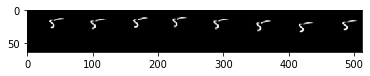

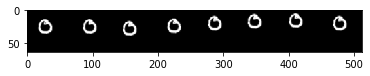

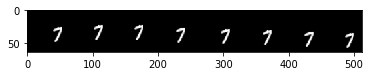

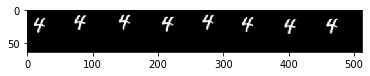

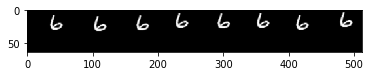

"\nprint('       x_current     |      x_reference')\nplt.imshow(np.hstack([x_curr,x_ref]), cmap='gray')\nplt.show()\n    \nprint('       x_current     |      x_reference')\nx_hat0 = np.load(f'{path}x_hat0.npz')['a'][0,0,:,:]\nx_hat1 = np.load(f'{path}x_hat1.npz')['a'][0,0,:,:]\nx_hat2 = np.load(f'{path}x_hat2.npz')['a'][0,0,:,:]\nx_hat3 = np.load(f'{path}x_hat3.npz')['a'][0,0,:,:]\nx_hat4 = np.load(f'{path}x_hat4.npz')['a'][0,0,:,:]\n\nplt.imshow(np.hstack([x_hat0,x_hat1,x_hat2,x_hat3,x_hat4]), cmap='gray')\nplt.show()\n"

In [5]:
import matplotlib.pyplot as plt

lambda_PN = []
path = './saved_models/R1-eps|_dim_128|z_dim_12|L_2|lambda_gp_10|bs_64|dpenalty_0.0|lambdaP_0.0|lambdaPN_0.0|lambdaMSE_1.0/'


x_curr = np.load(f'{path}x.npz')['a'][0,0,1,...]
x_ref = np.load(f'{path}x.npz')['a'][0,0,0,...]
x = np.load(f'{path}x.npz')['a']
print(x.shape)

for v in range(5):
    video = []
    for i in range(8):
        video.append(x[v,0,i,:,:])
    plt.imshow(np.hstack(video), cmap='gray')
    plt.show()
    
'''
print('       x_current     |      x_reference')
plt.imshow(np.hstack([x_curr,x_ref]), cmap='gray')
plt.show()
    
print('       x_current     |      x_reference')
x_hat0 = np.load(f'{path}x_hat0.npz')['a'][0,0,:,:]
x_hat1 = np.load(f'{path}x_hat1.npz')['a'][0,0,:,:]
x_hat2 = np.load(f'{path}x_hat2.npz')['a'][0,0,:,:]
x_hat3 = np.load(f'{path}x_hat3.npz')['a'][0,0,:,:]
x_hat4 = np.load(f'{path}x_hat4.npz')['a'][0,0,:,:]

plt.imshow(np.hstack([x_hat0,x_hat1,x_hat2,x_hat3,x_hat4]), cmap='gray')
plt.show()
'''

In [ ]:
main_new(dim = 128,
        z_dim = 12,
        lambda_gp = 10,
        bs = 64,
        d_penalty = 0,
        skip_fq = 1,
        total_epochs = 3,
        lambda_P = 0,
        lambda_PN = 0,
        lambda_MSE = 1,
        L = 2,
        path = './data/',
        pre_path = 'None')

Settings:  R1-eps|dim_128|z_dim_12|L_2|lambda_gp_10|bs_64|dpenalty_0|lambdaP_0|lambdaPM_0|lambdaMSE_1
[-1.0, 1.0]
[-1.0, 1.0]
Finished Loading MNIST!
0/937
0.3628246784210205
0.3306635022163391
0.3028711974620819
0.2787083387374878
0.25379347801208496
0.23185710608959198
0.21509625017642975
0.2020493596792221
0.1895059049129486
0.1736084520816803
0.16808314621448517
0.1601289063692093
0.147793710231781
0.14345335960388184
0.13896317780017853
0.13429290056228638
0.13191775977611542
0.12874507904052734
0.12076707184314728
0.11887286603450775
0.11542440205812454
0.11378762125968933
0.11296244710683823
0.11097872257232666
0.10412988066673279
0.10338439047336578
0.1023823618888855
0.10136085003614426
0.09903062880039215
0.09776449203491211
0.0970434844493866
0.09696976840496063
0.09654946625232697
0.08996689319610596
0.08959425985813141
0.09123285114765167
0.08625246584415436
0.0893346518278122
0.08828805387020111
0.08629836142063141
0.08365120738744736
0.08447464555501938
0.083971448242664

0.026836421340703964
0.026169031858444214
0.026678217574954033
400/937
0.027211744338274002
0.026904918253421783
0.025560526177287102
0.025374090299010277
0.029421648010611534
0.02665320411324501
0.02948063053190708
0.029659977182745934
0.02870335802435875
0.0311733428388834
0.026658646762371063
0.027410294860601425
0.0268804132938385
0.027852550148963928
0.028362566605210304
0.02654118835926056
0.026936616748571396
0.025315966457128525
0.027774963527917862
0.029610445722937584
0.026076510548591614
0.02504434436559677
0.026540838181972504
0.027279306203126907
0.026554161682724953
0.028018277138471603
0.025721468031406403
0.025497201830148697
0.025767076760530472
0.025874223560094833
0.02420632727444172
0.026979930698871613
0.025856563821434975
0.025764882564544678
0.02485721930861473
0.026595469564199448
0.02519848197698593
0.024398639798164368
0.02454891800880432
0.027883239090442657
0.024264805018901825
0.025694530457258224
0.02512742206454277
0.02438012883067131
0.02476823329925537


0.022382300347089767
0.020228412002325058
0.020083675161004066
0.01964884251356125
0.020778445526957512
0.020491912961006165
0.01888551190495491
800/937
0.018959512934088707
0.019330281764268875
0.020433269441127777
0.019716262817382812
0.019529052078723907
0.019014591351151466
0.019239641726017
0.019212232902646065
0.01865638792514801
0.018308395519852638
0.018924513831734657
0.018926016986370087
0.020031500607728958
0.01786578819155693
0.018999677151441574
0.019922368228435516
0.019127853214740753
0.01930018700659275
0.020420214161276817
0.01887098141014576
0.01951136253774166
0.018953019753098488
0.018635660409927368
0.0182430949062109
0.020736057311296463
0.018779098987579346
0.02015647105872631
0.019855067133903503
0.019472535699605942
0.01865270920097828
0.019166024401783943
0.019008982926607132
0.018074415624141693
0.018169179558753967
0.01861572265625
0.018785756081342697
0.017614733427762985
0.01850096881389618
0.01998702436685562
0.017994094640016556
0.01792340725660324
0.018

In [13]:
def main(dim = 128,
        z_dim = 1,
        lambda_gp = 10,
        bs = 64,
        d_penalty = 0,
        skip_fq = 5,
        total_epochs = 10,
        lambda_P = 0,
        lambda_PM = 0,
        lambda_MSE = 0,
        L = 2,
        path = './data/',
        pre_path = 'None'):
        
    #No quantization:
    stochastic = True
    quantize_latents = True
    if L == -1:
        stochastic = False
        quantize_latents = False
    print ('Stochastic: ', stochastic)
    print ('Quantize: ', quantize_latents)
    #Create folder:
    folder_name='New_R1eps_dim_'+str(dim)+'|z_dim_'+str(z_dim)+'|L_'+str(L)+'|lambda_gp_'+str(lambda_gp) \
        +'|bs_'+str(bs)+'|dpenalty_'+str(d_penalty)+'|lambdaP_'+str(lambda_P)+'|lambdaPM_'+str(lambda_PM)+'|lambdaMSE_' + str(lambda_MSE)
    print ("Settings: ", folder_name)

    os.makedirs('./saved_models/'+ folder_name, exist_ok=True)
    f = open('./saved_models/'+ folder_name + "/performance.txt", "a")

    #Define Models
    discriminator = Discriminator_v3(out_ch=2) #Generator Side
    discriminator_M = Discriminator_v3(out_ch=1) #Marginal Discriminator
    ssf = ScaleSpaceFlow_R1eps(num_levels=1, dim=z_dim, stochastic=stochastic, quantize_latents=quantize_latents, L=L)

    list_models = [discriminator, discriminator_M, ssf]

    ssf.cuda()
    discriminator.cuda()
    discriminator_M.cuda()
    

    #Load models:
    if pre_path != 'None':
        ssf.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
        ssf.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
        ssf.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
        ssf.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
        ssf.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
        discriminator.load_state_dict(torch.load(pre_path+'/discriminator.pth'))
        discriminator_M.load_state_dict(torch.load(pre_path+'/discriminator_M.pth'))
    


    #Define fixed model
    I_dim = 12 #12 #8
    I_L = 2
    encoder = Encoder(dim=I_dim, nc=1, stochastic=True, quantize_latents=True, L=I_L) #Generator Side
    decoder = Decoder_Iframe(dim=I_dim) #Generator Side
    decoder_hat = Decoder_Iframe(dim=I_dim)

    encoder.cuda()
    decoder.cuda()
    decoder_hat.cuda()

    encoder.eval()
    decoder.eval()
    decoder_hat.eval()
    encoder.load_state_dict(torch.load('./I3/I_frame_encoder_zdim_12_L_2.pth'))
    decoder.load_state_dict(torch.load('./I3/I_frame_decoderMMSE_zdim_12_L_2.pth'))
    decoder_hat.load_state_dict(torch.load('./I3/I_frame_decoder_zdim_12_L_2.pth'))

    #Define Data Loader
    train_loader, test_loader = get_dataloader(data_root=path, seq_len=8, batch_size=bs, num_digits=1)
    loader_l = len(train_loader)
    mse = torch.nn.MSELoss()

    #discriminator.train()
    opt_ssf= torch.optim.RMSprop(ssf.parameters(), lr=1e-5)
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=5e-5)
    opt_dm = torch.optim.RMSprop(discriminator_M.parameters(), lr=5e-5)

    list_opt = [opt_ssf, opt_d, opt_dm]

    
    for epoch in range(total_epochs):
        set_models_state(list_models, 'train')
        a1 = time.time()
        for i,x in enumerate(train_loader):
            print(f'{i}/{loader_l}')
            #Set 0 gradient
            set_opt_zero(list_opt)
            
            #Get the data
            x = x.permute(0, 4, 1, 2, 3)
            x = x.cuda().float()
            x_cur = x[:,:,1,...]
            with torch.no_grad():
                hx = encoder(x[:,:,0,...])[0]
                x_ref = decoder(hx).detach()
                x_1_hat = decoder_hat(hx).detach()
            #x_ref[x_ref < 0.1] = 0.0
            x_hat = ssf(x_cur, x_ref, x_1_hat)



            #Optimize discriminator
            fake_vid = torch.cat((x_1_hat, x_hat), dim = 1)
            real_vid = x[:,0,:2,...].detach() #this looks good!
            fake_validity = discriminator(fake_vid.detach())
            real_validity = discriminator(real_vid)
            gradient_penalty = compute_gradient_penalty(discriminator, real_vid.data, fake_vid.data)
            errVD =  -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            errVD.backward()
            opt_d.step()
            
            #Optimize discriminator M
            fake_img = x_hat.detach()
            real_img = x[:,0,:1,...].detach()
            fake_valid_m = discriminator_M(fake_img)
            real_valid_m = discriminator_M(real_img)
            gradient_penalty_m = compute_gradient_penalty(discriminator_M, fake_img.data, real_img.data)
            errID =  -torch.mean(real_valid_m) + torch.mean(fake_valid_m) + lambda_gp * gradient_penalty_m
            errID.backward()
            opt_dm.step()
            
            
            if i%skip_fq == 0:
                x_cur = x_cur.detach()
                x_ref = x_ref.detach()
                x_1_hat = x_1_hat.detach()
                x_hat = ssf(x_cur, x_ref, x_1_hat)

                fake_vid = torch.cat((x_1_hat, x_hat), dim = 1)
                fake_validity = discriminator(fake_vid)
                errVG = -torch.mean(fake_validity)

                fake_img = x_hat
                fake_validity_im = discriminator_M(fake_img)
                errIG = -torch.mean(fake_validity_im)

                loss = lambda_MSE*mse(x_hat, x_cur) + lambda_P*errVG + lambda_PM*errIG
                loss.backward()

                opt_ssf.step()
        a = time.time()
        if epoch %10 == 0:
            show_str= "Epoch: "+ str(epoch) + "l_PM, l_P, l_MSE, d_penalty " + str(lambda_PM) + str(lambda_P)+ " " \
            +str(lambda_MSE) + " " + str(d_penalty) + " P loss: " + str(cal_W1(ssf, encoder, decoder, decoder_hat, discriminator, discriminator_M, test_loader, list_models))
            print (show_str)
            f.write(show_str+"\n")
        b = time.time()
        print('test time:', b-a)
            
        b1 = time.time()
        print(f'epoch: {b1-a1}')
    #show_str= "Epoch: "+ str(epoch) + "l_PM, l_P, l_MSE, d_penalty " + str(lambda_PM) + str(lambda_P)+ " " \
    #        +str(lambda_MSE) + " " + str(d_penalty) + " P loss: " + str(cal_W1(ssf, encoder, decoder, decoder_hat, discriminator, discriminator_M, test_loader, list_models))
    #print (show_str)
    #f.write(show_str+"\n")


    set_models_state(list_models, 'eval')
    a = time.time()
    torch.save(ssf.motion_encoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'm_enc.pth'))
    torch.save(ssf.motion_decoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'm_dec.pth'))
    torch.save(ssf.P_encoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'p_enc.pth'))
    torch.save(ssf.res_encoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'r_enc.pth'))
    torch.save(ssf.res_decoder.state_dict(), os.path.join("./saved_models/" + folder_name, 'r_dec.pth' ))
    torch.save(discriminator.state_dict(), os.path.join("./saved_models/" + folder_name, 'discriminator.pth'))
    torch.save(discriminator_M.state_dict(), os.path.join("./saved_models/" + folder_name, 'discriminator_M.pth'))
    b = time.time()
    print(f'save models: {b-a}')
    f.close()

    #save some figures
    for i,x in enumerate(iter(train_loader)):
        x = x.permute(0, 4, 1, 2, 3)
        x = x.cuda().float()
        break
    np.savez_compressed("./saved_models/" + folder_name+"/x", a=x.detach().cpu().numpy())

    for i in range(5): #generate same figure 5 times
        x_cur = x[:,:,1,...]
        x_ref = x[:,:,0,...]
        x_hat = ssf(x_cur, x_ref)
        np.savez_compressed("./saved_models/" + folder_name+"/x_hat"+str(i), a=x_hat.detach().cpu().numpy())
